In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
from PIL import Image
import nibabel as nb
import os

In [2]:
import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.fan_equiangular as ct_fan
import ct_projector.projector.numpy as numpy_projector
import ct_projector.projector.numpy.fan_equiangluar as numpy_fan

In [55]:
# load a sample CT image
# filename = '/workspace/Documents/data/CT_motion/CT_images/example_CT_volume/patient_3/original/3.nii.gz'
filename = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/MO101701M000001/MO001A000001/img-nii-2.5/img.nii.gz'
ct = nb.load(filename)
affine = ct.affine
img = ct.get_fdata()
spacing = ct.header.get_zooms()

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = np.rollaxis(img,-1,0)
img = img[np.newaxis, ...]
# img = img[:, ::-1, ...]
spacing = np.array(spacing[::-1])
print(img.shape)
print(spacing)

(1, 66, 220, 220)
[2.5094697 1.0000012 1.0000012]


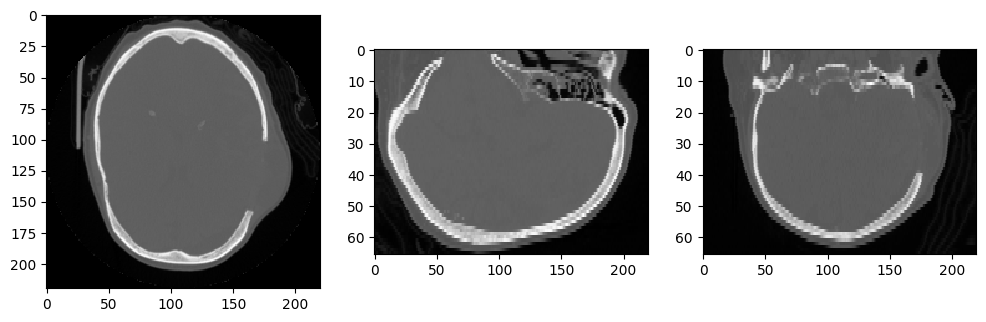

In [56]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...].T, 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

In [73]:
# setup the projector
projector = ct_projector.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = 1
projector.nv = 1
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]
projector.nview = 768 # 768 for high-resolution, 1440 for low resolution

nyquist = projector.dx * projector.dsd / projector.dso / 2

# projector.du = nyquist  # change it if low-resolution


for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 768
rotview = 720
nu = 736
nv = 1
nx = 220
ny = 220
nz = 1
dx = 1.0000012
dy = 1.0000012
dz = 2.5094697
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x7fa1ba260dc0>


In [74]:
def get_angles_zc(nview, total_angle,start_angle):
    return np.arange(0, nview, dtype=np.float32) * (total_angle / 180 * np.pi) / nview + start_angle

In [75]:
# very important: make sure that the arrays are saved in C order
cp.cuda.Device(0).use()
ct_projector.set_device(0)

# angles = projector.get_angles()
angles = get_angles_zc(projector.nview, 360,0)
print(angles.shape)
# origin_img = img[0, [img.shape[1]//3, img.shape[1]//2, img.shape[1]//3*2], ...]
origin_img = img[0, ...]
origin_img = origin_img[:, np.newaxis, ...]
print(origin_img.shape)
cuimg = cp.array(origin_img, cp.float32, order = 'C')
cuangles = cp.array(angles, cp.float32, order = 'C')

projector.set_projector(ct_fan.distance_driven_fp, angles=cuangles, branchless=False)

(768,)
(66, 1, 220, 220)


0.18411755561828613
(66, 768, 1, 736)


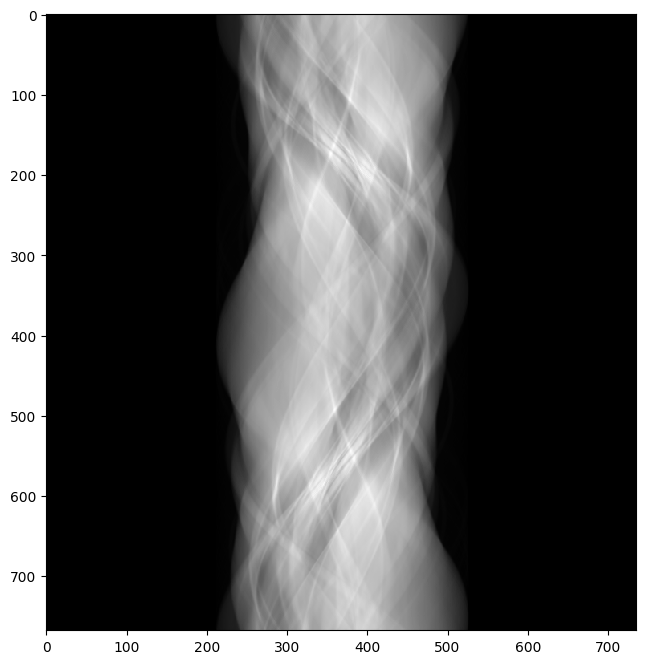

In [76]:
# set which device to use
numpy_projector.set_device(0)
# forward projection
start = time.time()
cufp = projector.fp(cuimg, angles = cuangles)
end = time.time()
print (end - start)

# show the projections
fp = cufp.get()
print(fp.shape)
plt.figure(figsize = (8,8))
a = fp[1,:, 0, :]
plt.imshow(a, 'gray')

In [77]:
fbp_projector = numpy_projector.ct_projector()
fbp_projector.from_file('./projector_fan.cfg')
fbp_projector.nx = img.shape[3]
fbp_projector.ny = img.shape[2]
fbp_projector.nz = 1
fbp_projector.nv = 1
fbp_projector.dx = spacing[2]
fbp_projector.dy = spacing[1]
fbp_projector.dz = spacing[0]

# fbp_projector.du = nyquist
# fbp_projector.nu = fbp_projector.nu * 2

for k in vars(fbp_projector):
    print (k, '=', getattr(fbp_projector, k))



nview = 2304
rotview = 720
nu = 736
nv = 1
nx = 220
ny = 220
nz = 1
dx = 1.0000012
dy = 1.0000012
dz = 2.5094697
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x7fa1ba075340>


In [71]:
fprj = numpy_fan.ramp_filter(fbp_projector, fp, filter_type='RL')
# fprj = numpy_fan.ramp_filter(fbp_projector, projection, filter_type='RL')
recon = numpy_fan.fbp_bp(fbp_projector, fprj, angles)
print(recon.shape)

(66, 1, 220, 220)


In [78]:
# save recon
recon_nb = np.rollaxis(recon[:,0,:,:],0,3)
print(recon_nb.shape)
recon_nb = recon_nb / 0.019 * 1000 - 1024
recon_nb = nb.Nifti1Image(recon_nb,affine)
nb.save(recon_nb, os.path.join('/mnt/mount_zc_NAS/motion_correction/data','recon.nii.gz'))

(220, 220, 66)


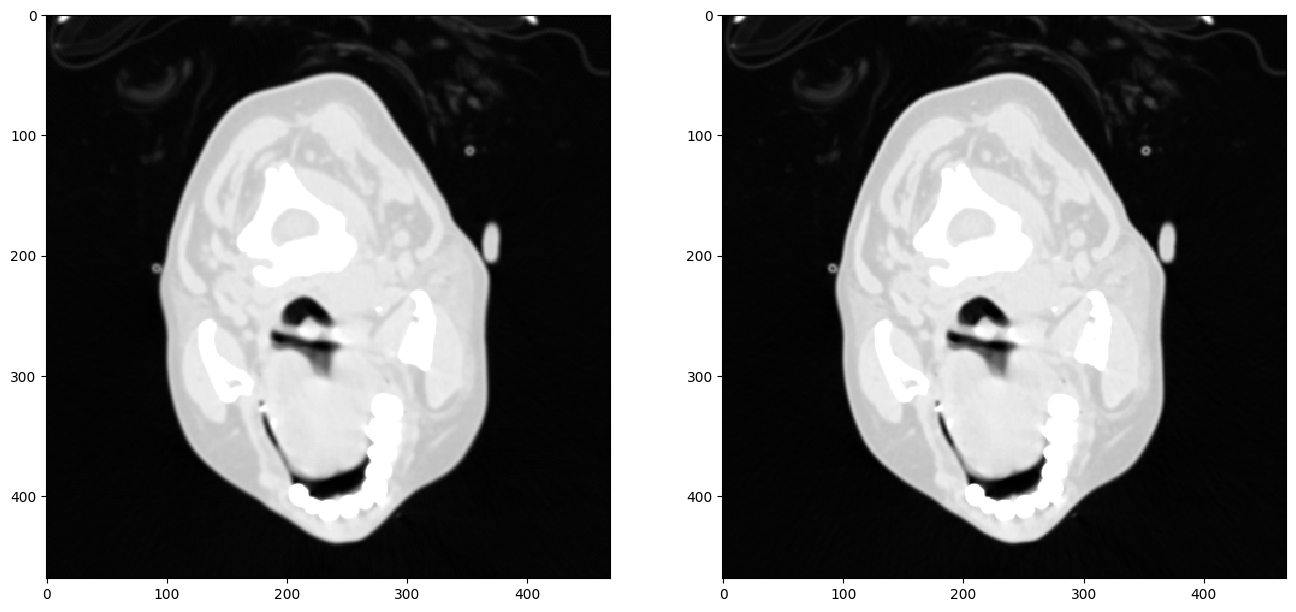

In [19]:
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(recon[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)
plt.subplot(122); plt.imshow(cuimg.get()[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)

In [21]:
projector.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp=True)
cufprj = cp.array(fprj, cp.float32, order = 'C')
curecon = projector.bp(cufprj)

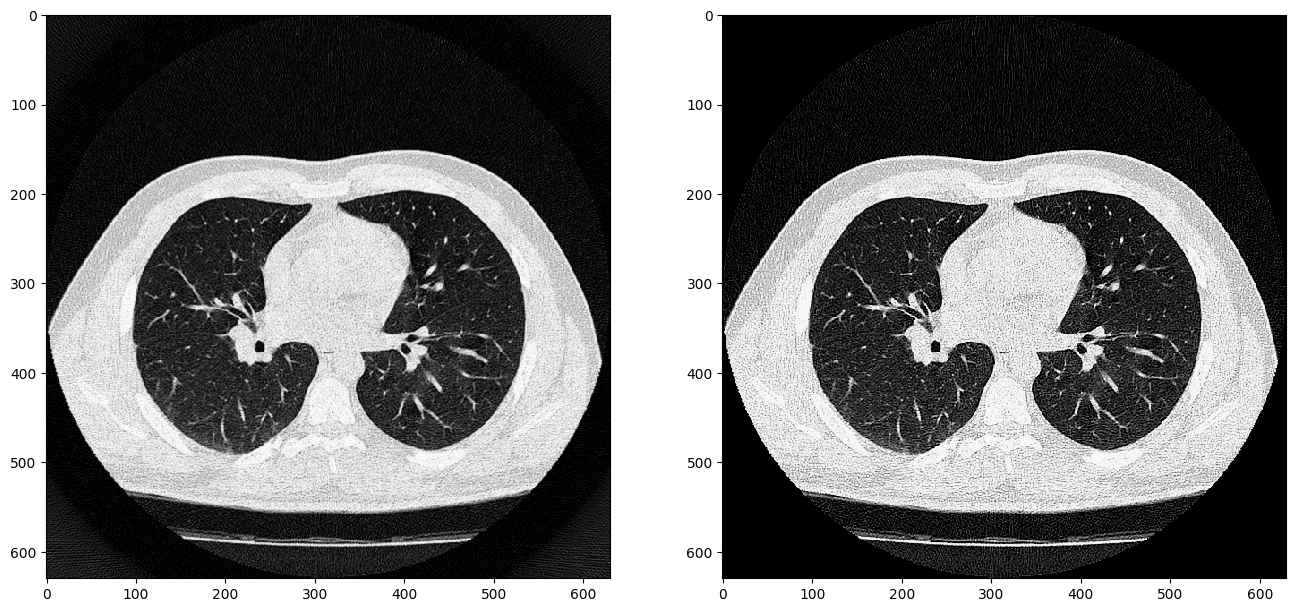

In [22]:
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(curecon.get()[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)
plt.subplot(122); plt.imshow(cuimg.get()[2,0, :, :].T, 'gray', vmin=0, vmax=0.0225)